In [ ]:
import os
import zipfile
with zipfile.ZipFile('/content/tiny_imagenet200.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tiny_imagenet200')
# Data preprocessing

Epoch [1/20], Total Loss: 329.8178, Reconstruction Loss: 311.9574, KL Divergence: 178.6042
Epoch [2/20], Total Loss: 256.2846, Reconstruction Loss: 223.2373, KL Divergence: 165.2368
Epoch [3/20], Total Loss: 257.9964, Reconstruction Loss: 214.0947, KL Divergence: 146.3390
Epoch [4/20], Total Loss: 266.4605, Reconstruction Loss: 214.1718, KL Divergence: 130.7216
Epoch [5/20], Total Loss: 275.9610, Reconstruction Loss: 217.4276, KL Divergence: 117.0667
Epoch [6/20], Total Loss: 285.0694, Reconstruction Loss: 221.5889, KL Divergence: 105.8008
Epoch [7/20], Total Loss: 293.9166, Reconstruction Loss: 226.4582, KL Divergence: 96.3692
Epoch [8/20], Total Loss: 301.9816, Reconstruction Loss: 231.1125, KL Divergence: 88.5863
Epoch [9/20], Total Loss: 309.8537, Reconstruction Loss: 236.0604, KL Divergence: 81.9926
Epoch [10/20], Total Loss: 317.0425, Reconstruction Loss: 240.7781, KL Divergence: 76.2643
Epoch [11/20], Total Loss: 316.2799, Reconstruction Loss: 240.4814, KL Divergence: 75.7985
Ep

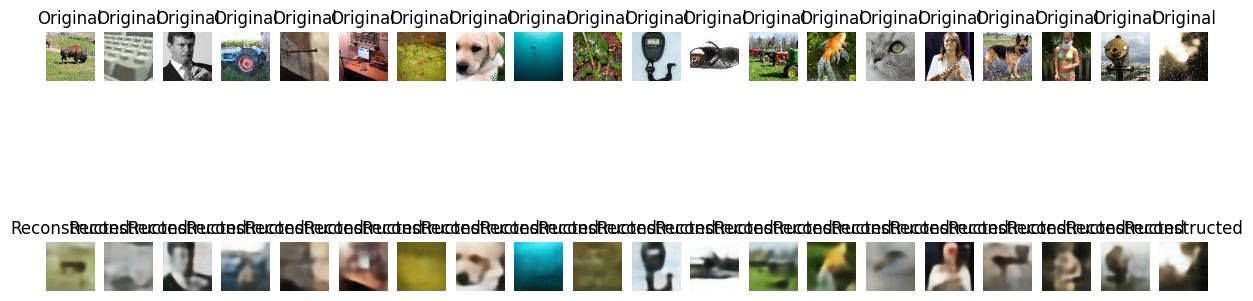

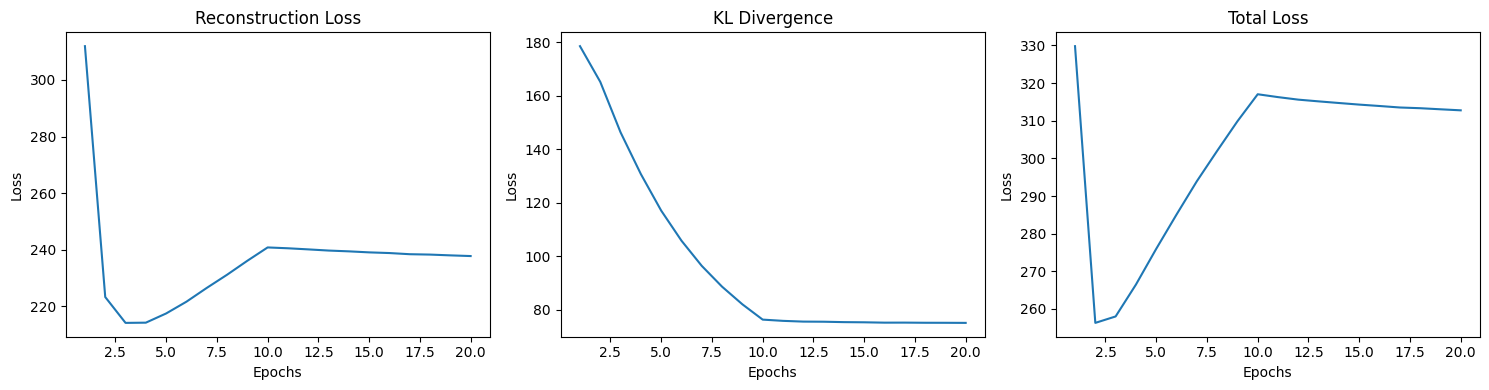

<ipython-input-53-11af44ef4f0c>:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("/content/vae_model_one_more_layer.pkl", map_location=devic

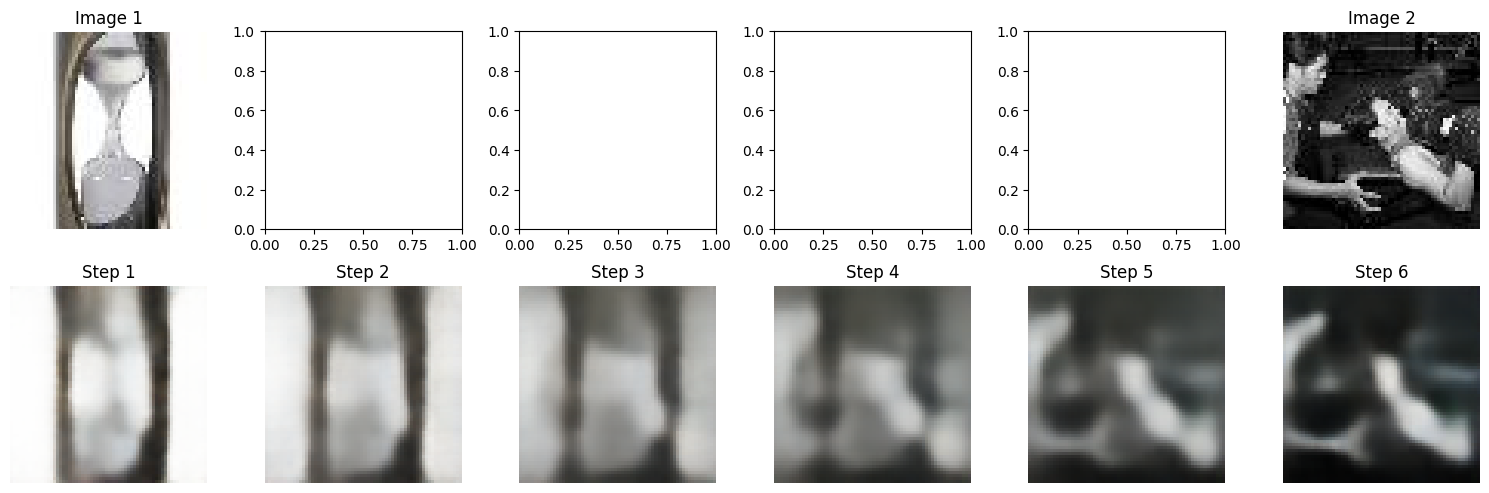

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# Define the VAE model
class VAE_4_LAYERS(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_4_LAYERS, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(x.size(0), 512, 4, 4)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Data preparation
def prepare_data(batch_size=64, img_size=64):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        #transforms.Normalize([0.5], [0.5])
    ])
    dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Training function
def train_vae_4_layers(model, data_loader, computation_device, training_epochs=20):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    training_history = {"reconstruction_loss": [], "kl_divergence": [], "total_loss": []}

    for current_epoch in range(training_epochs):
        epoch_reconstruction_loss = 0
        epoch_kl_divergence = 0
        epoch_total_loss = 0

        for batch_index, (images, _) in enumerate(data_loader):
            images = images.to(computation_device)
            optimizer.zero_grad()

            reconstructed_images, latent_mean, latent_log_variance = model(images)

            reconstruction_loss = nn.functional.mse_loss(reconstructed_images, images, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + latent_log_variance - latent_mean.pow(2) - latent_log_variance.exp())

            kl_weight = min(1.0, (current_epoch + 1) / 10)
            total_loss = reconstruction_loss + kl_weight * kl_divergence

            total_loss.backward()
            optimizer.step()

            epoch_reconstruction_loss += reconstruction_loss.item()
            epoch_kl_divergence += kl_divergence.item()
            epoch_total_loss += total_loss.item()

        avg_reconstruction = epoch_reconstruction_loss / len(data_loader.dataset)
        avg_kl = epoch_kl_divergence / len(data_loader.dataset)
        avg_total = epoch_total_loss / len(data_loader.dataset)

        training_history["reconstruction_loss"].append(avg_reconstruction)
        training_history["kl_divergence"].append(avg_kl)
        training_history["total_loss"].append(avg_total)

        print(f"Epoch [{current_epoch + 1}/{training_epochs}], Total Loss: {avg_total:.4f}, "
              f"Reconstruction Loss: {avg_reconstruction:.4f}, KL Divergence: {avg_kl:.4f}")

    model_save_path = "vae_model_weights.pkl"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model weights saved to '{model_save_path}'")
    return training_history

# Visualization
def visualize_latent_space(model, dataloader, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z).cpu()

        plt.figure(figsize=(10, 5))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(samples[i].permute(1, 2, 0))
            plt.axis('off')
        plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
TRAIN_PATH =  './tiny_imagenet200/tiny-imagenet-200/train'
vae = VAE_4_LAYERS(latent_dim).to(device)
dataloader = prepare_data()
history= train_vae_4_layers(vae, dataloader, device)


torch.save(vae.state_dict(), "vae_model_one_more_layer.pkl")
visualize_reconstructions(vae, dataloader)


def plot_training_metrics(training_history):
    epochs = range(1, len(training_history["total_loss"]) + 1)

    plt.figure(figsize=(15, 4))
    plt.subplot(131)
    plt.plot(epochs, training_history["reconstruction_loss"])
    plt.title("Reconstruction Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(132)
    plt.plot(epochs, training_history["kl_divergence"])
    plt.title("KL Divergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(133)
    plt.plot(epochs, training_history["total_loss"])
    plt.title("Total Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()



plot_training_metrics(history)
vae.load_state_dict(torch.load("/content/vae_model_one_more_layer.pkl", map_location=device))
vae.eval()
with torch.no_grad():
    images, _ = next(iter(dataloader))
    image1, image2 = images[0].to(device), images[1].to(device)
    mu1, logvar1 = vae.encode(image1.unsqueeze(0))
    mu2, logvar2 = vae.encode(image2.unsqueeze(0))

    z1 = vae.reparameterize(mu1, logvar1)
    z2 = vae.reparameterize(mu2, logvar2)

    num_steps =6
    interpolation = torch.linspace(0, 1, num_steps).to(device)
    z_interpolated = torch.stack([z1 * (1 - alpha) + z2 * alpha for alpha in interpolation])

    reconstructed_images = vae.decode(z_interpolated).cpu()

    fig, axes = plt.subplots(2, num_steps, figsize=(15, 5))

    axes[0, 0].imshow(image1.permute(1, 2, 0).cpu().numpy())
    axes[0, 0].axis('off')
    axes[0, 0].set_title("Image 1")

    axes[0, -1].imshow(image2.permute(1, 2, 0).cpu().numpy())
    axes[0, -1].axis('off')
    axes[0, -1].set_title("Image 2")

    # Interpolated images
    for i in range(num_steps):
        axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0).numpy())
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Step {i+1}")

    plt.tight_layout()
    plt.show()


<ipython-input-68-f315f5ce6313>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("/content/vae_model_one_more_layer.pkl", map_location=device)

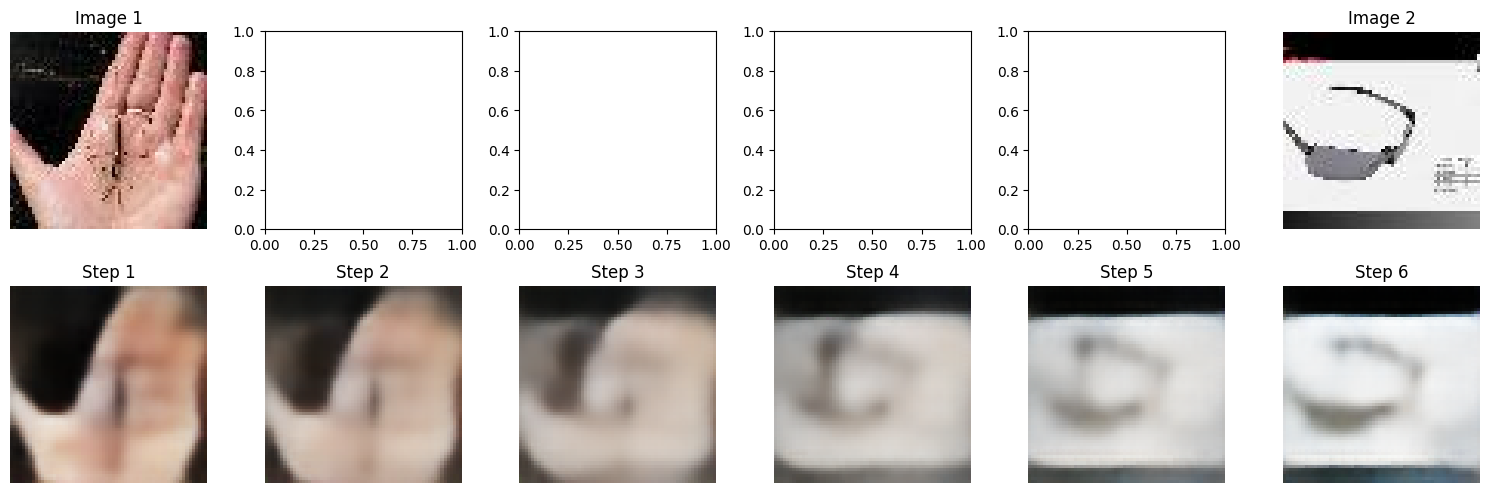

In [ ]:
vae.load_state_dict(torch.load("/content/vae_model_one_more_layer.pkl", map_location=device))
vae.eval()
with torch.no_grad():
    images, _ = next(iter(dataloader))
    image1, image2 = images[0].to(device), images[1].to(device)
    mu1, logvar1 = vae.encode(image1.unsqueeze(0))
    mu2, logvar2 = vae.encode(image2.unsqueeze(0))

    z1 = vae.reparameterize(mu1, logvar1)
    z2 = vae.reparameterize(mu2, logvar2)

    num_steps =6
    interpolation = torch.linspace(0, 1, num_steps).to(device)
    z_interpolated = torch.stack([z1 * (1 - alpha) + z2 * alpha for alpha in interpolation])

    reconstructed_images = vae.decode(z_interpolated).cpu()

    fig, axes = plt.subplots(2, num_steps, figsize=(15, 5))

    axes[0, 0].imshow(image1.permute(1, 2, 0).cpu().numpy())
    axes[0, 0].axis('off')
    axes[0, 0].set_title("Image 1")

    axes[0, -1].imshow(image2.permute(1, 2, 0).cpu().numpy())
    axes[0, -1].axis('off')
    axes[0, -1].set_title("Image 2")

    # Interpolated images
    for i in range(num_steps):
        axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0).numpy())
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Step {i+1}")

    plt.tight_layout()
    plt.show()
